<a href="https://colab.research.google.com/github/kokchun/Deep-learning-AI21/blob/main/Lectures/Lec6-RNN.ipynb" target="_parent"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp; for interacting with the code

---
# Lecture notes - Recurrent neural networks (RNN)
---

This is the lecture note for **RNN**. 

<p class = "alert alert-info" role="alert"><b>Note</b> that this lecture note gives a brief introduction to RNN. I encourage you to read further about RNN. </p>

Read more:
- [RNN - wikipedia](https://en.wikipedia.org/wiki/Recurrent_neural_network)
- [LSTM - wikipedia](https://en.wikipedia.org/wiki/Long_short-term_memory)
- [LSTM - Colah (2015) blog post](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)
- [Time series forecasting - Brownlee (2016) machinelearningmastery](https://machinelearningmastery.com/time-series-forecasting/)
- [TimeSeriesGenerator - Brownlee (2016) machinelearningmastery](https://machinelearningmastery.com/how-to-use-the-timeseriesgenerator-for-time-series-forecasting-in-keras/)
- [TimeSeriesGenerator keras - TensorFlow](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/TimeseriesGenerator?version=nightly)


---

## Simulate time series

Time series are usually represented as 3D tensors (batch_size, time_steps, dimensionality). Dimensions is 1 for univariate time series. 

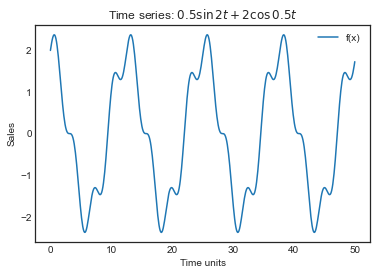

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use("seaborn-white")

f = lambda t: 0.5 * np.sin(2 * t) + 2 * np.cos(0.5 * t)

x = np.linspace(0, 50, 500)
df = pd.DataFrame(f(x), index=x, columns=["f(x)"])

df.plot(
    title=r"Time series: $0.5 \sin{2t}+2 \cos{0.5t}$",
    ylabel="Sales",
    xlabel="Time units",
);


---
## Train|test split

For timeseries we split the first section as training and the rest as test, as it is the test part that we are interested in predicting which is the "future" in the perspective of the training data. The idea is analogous for train|validation|test split. 

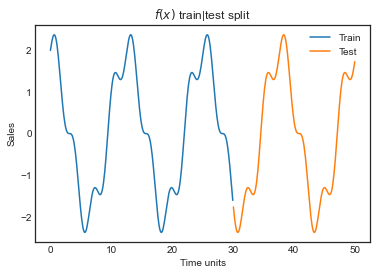

In [2]:
test_split = 200
df_train = df.iloc[:-test_split]
df_test = df.iloc[-test_split:]

ax = plt.axes()
df_train.plot(
    ax=ax,
    title=r"$f(x)$ train|test split",
    ylabel="Sales",
    xlabel="Time units"
)
df_test.plot(ax=ax)
ax.legend(["Train", "Test"]);


---
## Scale data

RNN uses backpropagation through time (BPTT) to calculate gradients for an optimization algorithm to adjust the weights to minimize a loss function. Hence, the data need to be scaled before using in order for it to learn properly. 

In [3]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(df_train)
scaled_test = scaler.transform(df_test)

print(f"{scaled_train.shape=}, {scaled_test.shape=}")

scaled_test.min(), scaled_test.max()

scaled_train.shape=(300, 1), scaled_test.shape=(200, 1)


(0.00011292154516773234, 0.9994100860551354)

---
## Generate time series batches

We need to generate time series batches of the form (batch_size, time_steps, dimensionality) as input to RNN 

Before we generate batches we need to determine the batch length. You should pick a batch length that captures the seasonality (periodicity), but is smaller than the test data.

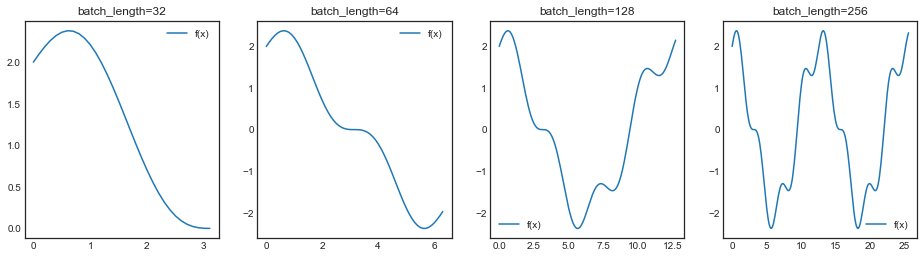

In [4]:
batch_lengths = [32, 64, 128, 256]
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

for batch_length, ax in zip(batch_lengths, axes):
    df_train.iloc[:batch_length].plot(ax=ax)
    ax.set_title(f"{batch_length=}")

# we can't pick 256 as our test size is only 200

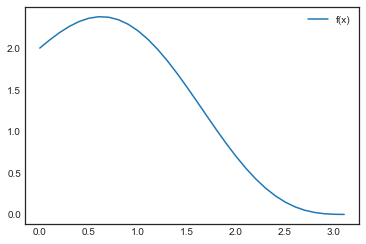

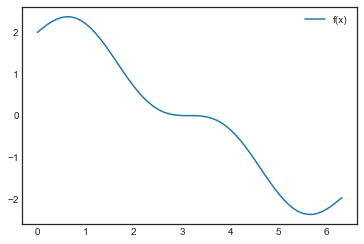

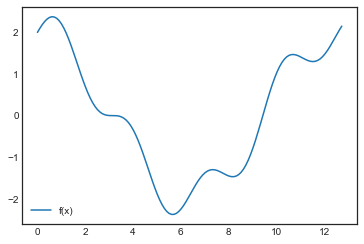

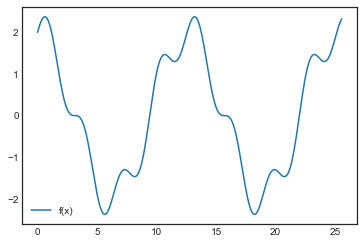

In [7]:
batch_lengths = [32, 64, 128, 256]

for batch_length in batch_lengths:
    df_train.iloc[:batch_length].plot()
    ax.set_title(f"{batch_length=}")

# we can't pick 256 as our test size is only 200

In [8]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

batch_length = 128  # how much data points as input for predicting next output
batch_size = 1  # how large the predicted output should be as
# 1 batch givesone output

# data and targets are usually same time series
train_generator = TimeseriesGenerator(
    scaled_train, scaled_train, length=batch_length, batch_size=batch_size
)

test_generator = TimeseriesGenerator(
    scaled_test, scaled_test, length=batch_length, batch_size=batch_size
)
X, y = train_generator[0]
X.shape, y.shape


((1, 128, 1), (1, 1))

In [13]:
train_generator[0]

(array([[[9.20601281e-01],
         [9.41005828e-01],
         [9.59518312e-01],
         [9.75338396e-01],
         [9.87734108e-01],
         [9.96071388e-01],
         [9.99839809e-01],
         [9.98673456e-01],
         [9.92366107e-01],
         [9.80880129e-01],
         [9.64348703e-01],
         [9.43071321e-01],
         [9.17502703e-01],
         [8.88235594e-01],
         [8.55978117e-01],
         [8.21526596e-01],
         [7.85734922e-01],
         [7.49481691e-01],
         [7.13636430e-01],
         [6.79026251e-01],
         [6.46404272e-01],
         [6.16421054e-01],
         [5.89600212e-01],
         [5.66319148e-01],
         [5.46795697e-01],
         [5.31081199e-01],
         [5.19060271e-01],
         [5.10457302e-01],
         [5.04849376e-01],
         [5.01685130e-01],
         [5.00308769e-01],
         [4.99988275e-01],
         [4.99946688e-01],
         [4.99395184e-01],
         [4.97566629e-01],
         [4.93748272e-01],
         [4.87312240e-01],
 

In [12]:
train_generator[1]

(array([[[9.41005828e-01],
         [9.59518312e-01],
         [9.75338396e-01],
         [9.87734108e-01],
         [9.96071388e-01],
         [9.99839809e-01],
         [9.98673456e-01],
         [9.92366107e-01],
         [9.80880129e-01],
         [9.64348703e-01],
         [9.43071321e-01],
         [9.17502703e-01],
         [8.88235594e-01],
         [8.55978117e-01],
         [8.21526596e-01],
         [7.85734922e-01],
         [7.49481691e-01],
         [7.13636430e-01],
         [6.79026251e-01],
         [6.46404272e-01],
         [6.16421054e-01],
         [5.89600212e-01],
         [5.66319148e-01],
         [5.46795697e-01],
         [5.31081199e-01],
         [5.19060271e-01],
         [5.10457302e-01],
         [5.04849376e-01],
         [5.01685130e-01],
         [5.00308769e-01],
         [4.99988275e-01],
         [4.99946688e-01],
         [4.99395184e-01],
         [4.97566629e-01],
         [4.93748272e-01],
         [4.87312240e-01],
         [4.77742633e-01],
 

In [14]:
train_generator[2]

(array([[[9.59518312e-01],
         [9.75338396e-01],
         [9.87734108e-01],
         [9.96071388e-01],
         [9.99839809e-01],
         [9.98673456e-01],
         [9.92366107e-01],
         [9.80880129e-01],
         [9.64348703e-01],
         [9.43071321e-01],
         [9.17502703e-01],
         [8.88235594e-01],
         [8.55978117e-01],
         [8.21526596e-01],
         [7.85734922e-01],
         [7.49481691e-01],
         [7.13636430e-01],
         [6.79026251e-01],
         [6.46404272e-01],
         [6.16421054e-01],
         [5.89600212e-01],
         [5.66319148e-01],
         [5.46795697e-01],
         [5.31081199e-01],
         [5.19060271e-01],
         [5.10457302e-01],
         [5.04849376e-01],
         [5.01685130e-01],
         [5.00308769e-01],
         [4.99988275e-01],
         [4.99946688e-01],
         [4.99395184e-01],
         [4.97566629e-01],
         [4.93748272e-01],
         [4.87312240e-01],
         [4.77742633e-01],
         [4.64658111e-01],
 

In [9]:
# same values
X[0,-5:,0], scaled_train[batch_length-5:batch_length].flatten()

(array([0.8686539 , 0.89018132, 0.91183131, 0.93277341, 0.95216592]),
 array([0.8686539 , 0.89018132, 0.91183131, 0.93277341, 0.95216592]))

In [10]:
print("Next value to be predicted")
y, scaled_train[batch_length]

Next value to be predicted


(array([[0.96918959]]), array([0.96918959]))

---
## RNN 

RNN has a short-term dependancy as it is processing a sequence of data. The state of the current unit is provided as input together with next element in a sequence to the next unit. It is these hidden states $h_1, \ldots, h_t$ that gives the RNN its memory. 

Problems with RNN are: 
- exploding gradients
- vanishing gradients 
- can't process longer sequences well

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense


def RNN_model(RNN_layers: "Sequential"):
    model = Sequential(name="RNN")
    model.add(RNN_layers)
    model.add(Dense(1)) # linear layer
    model.compile(loss="mse", optimizer="adam")
    return model

# note that if we want hidden layers return_sequences need to be set to True except for last layer before dense
RNN_layers = SimpleRNN(batch_length, return_sequences=False, input_shape=(None, 1))

model = RNN_model(RNN_layers)

model.summary()


Model: "RNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 128)               16640     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 16,769
Trainable params: 16,769
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.fit(train_generator, epochs=5, validation_data=test_generator)


Epoch 1/5
172/172 [==============================] - 9s 38ms/step - loss: 0.0263 - val_loss: 0.0037
Epoch 2/5
172/172 [==============================] - 5s 27ms/step - loss: 0.0083 - val_loss: 0.0031
Epoch 3/5
172/172 [==============================] - 5s 27ms/step - loss: 0.0062 - val_loss: 0.0098
Epoch 4/5
172/172 [==============================] - 5s 27ms/step - loss: 0.0046 - val_loss: 0.0032
Epoch 5/5
172/172 [==============================] - 5s 27ms/step - loss: 0.0021 - val_loss: 0.0021


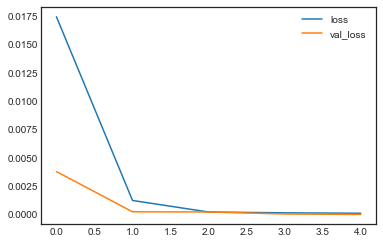

In [10]:
df_loss = pd.DataFrame(model.history.history)
df_loss.plot();

---
## Predictions

As the network predicts one value at a time with the setting we have chosen, we need to loop and create new batches of data so that it properly predicts next value in the time series.

In [11]:
predictions = np.zeros([len(scaled_test),1])
# picks out last data points in training data as first batch
first_batch = scaled_train[-batch_length:]
print(f"{first_batch.shape=}")
# need shape (batch_size, batch_length, dimensions)
new_batch = first_batch[None, :]
print(f"{new_batch.shape=}")

for i, _ in enumerate(df_test.values):
    new_pred = model.predict(new_batch)
    predictions[i] = new_pred[0]
    # role one step forward to build new batch for next prediction
    new_batch = np.append(new_batch[:, batch_size:, :], [new_pred], axis=1)

y_pred = scaler.inverse_transform(predictions)

y_pred[:3], df_test.iloc[:3].values

first_batch.shape=(128, 1)
new_batch.shape=(1, 128, 1)


(array([[-1.75000854],
        [-1.89730843],
        [-2.02386598]]),
 array([[-1.76620533],
        [-1.91336611],
        [-2.04466812]]))

In [12]:
df_test.insert(df_test.shape[1], "preds_RNN", y_pred)
df_test

,f(x),preds_RNN
30.060120,-1.766205,-1.750009
30.160321,-1.913366,-1.897308
30.260521,-2.044668,-2.023866
30.360721,-2.156987,-2.128065
30.460922,-2.247799,-2.211116
...,...,...
49.599198,1.404160,1.824598
49.699399,1.467753,1.712391
49.799599,1.544646,1.603813
49.899800,1.632719,1.495376


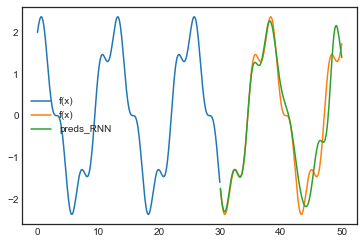

In [13]:
# we clearly see that the RNN is good at predicting in the beginning
# but becomes worse the longer time it takes as we make predictions
# on predictions leading to errors in errors
ax = df_train.plot()
df_test.plot(ax = ax);

---
## LSTM

LSTM - Long short term memory cell has both a long-term dependency part and a short-term dependency part. In more details it has a forget gate, input gate and an output gate with weights to regulate how much information to retain in hidden state and long term memory. 

Let's see if it can better predict the future.

In [14]:
from tensorflow.keras.layers import LSTM

LSTM_layer = LSTM(batch_length, return_sequences=False, input_shape=(None, 1))
model = RNN_model(LSTM_layer)
model.summary()


Model: "RNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.fit(train_generator, epochs=10, validation_data=test_generator)


Epoch 1/10
172/172 [==============================] - 9s 43ms/step - loss: 0.0265 - val_loss: 0.0052
Epoch 2/10
172/172 [==============================] - 7s 42ms/step - loss: 0.0030 - val_loss: 0.0017
Epoch 3/10
172/172 [==============================] - 7s 39ms/step - loss: 9.9962e-04 - val_loss: 5.6978e-04
Epoch 4/10
172/172 [==============================] - 8s 44ms/step - loss: 7.7752e-04 - val_loss: 5.3712e-04
Epoch 5/10
172/172 [==============================] - 7s 40ms/step - loss: 7.3411e-04 - val_loss: 5.8964e-04
Epoch 6/10
172/172 [==============================] - 7s 42ms/step - loss: 4.0801e-04 - val_loss: 2.2702e-04
Epoch 7/10
172/172 [==============================] - 9s 50ms/step - loss: 1.0704e-04 - val_loss: 1.1915e-04
Epoch 8/10
172/172 [==============================] - 8s 46ms/step - loss: 1.1563e-04 - val_loss: 1.6493e-04
Epoch 9/10
172/172 [==============================] - 7s 43ms/step - loss: 6.8208e-05 - val_loss: 3.3764e-05
Epoch 10/10
172/172 [==============

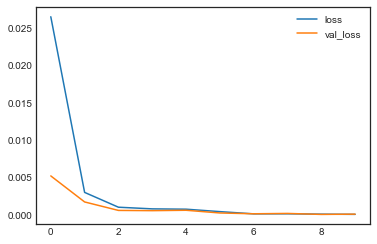

In [16]:
df_loss = pd.DataFrame(model.history.history)
df_loss.plot();

In [17]:
predictions = np.zeros([len(scaled_test),1])
first_batch = scaled_train[-batch_length:]
new_batch = first_batch[None, :]

for i, _ in enumerate(df_test.values):
    new_pred = model.predict(new_batch)
    predictions[i] = new_pred[0]
    # role one step forward to build new batch for next prediction
    new_batch = np.append(new_batch[:, batch_size:, :], [new_pred], axis=1)

y_pred = scaler.inverse_transform(predictions)
y_pred[:3], df_test.iloc[:3].values

(array([[-1.74718085],
        [-1.88964179],
        [-2.0148221 ]]),
 array([[-1.76620533, -1.75000854],
        [-1.91336611, -1.89730843],
        [-2.04466812, -2.02386598]]))

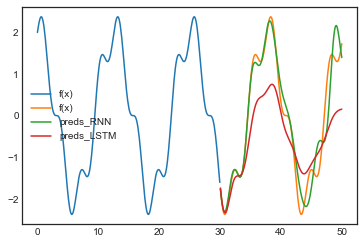

In [18]:
df_test.insert(df_test.shape[1], "preds_LSTM", y_pred)
#df_test["preds_LSTM"] = y_pred
ax = df_train.plot()
df_test.plot(ax = ax);

# probably need longer training here and/or maybe some hidden layer to learn the structures

---
## Forecasting 

Now we will forecast into the future, which we haven't seen yet. This means that there is no way in beforehand to tell how the prediction goes. We will however pick our LSTM model as it seems to have learned the test data well. 

In [19]:
scaler = MinMaxScaler()
all_data = scaler.fit_transform(df)
all_data_generator = TimeseriesGenerator(
    all_data, all_data, length=batch_length, batch_size=batch_size
)

LSTM_layer = LSTM(batch_length, return_sequences=False, input_shape=(None, 1))
model = RNN_model(LSTM_layer)

model.fit(all_data_generator, epochs=10)


Epoch 1/10
372/372 [==============================] - 16s 39ms/step - loss: 0.0127
Epoch 2/10
372/372 [==============================] - 15s 40ms/step - loss: 9.9473e-04
Epoch 3/10
372/372 [==============================] - 15s 41ms/step - loss: 6.8329e-04
Epoch 4/10
372/372 [==============================] - 15s 40ms/step - loss: 4.2083e-04
Epoch 5/10
372/372 [==============================] - 15s 40ms/step - loss: 6.1047e-05
Epoch 6/10
372/372 [==============================] - 15s 41ms/step - loss: 1.1992e-05
Epoch 7/10
372/372 [==============================] - 14s 38ms/step - loss: 8.5591e-06
Epoch 8/10
372/372 [==============================] - 15s 40ms/step - loss: 4.8880e-05
Epoch 9/10
372/372 [==============================] - 15s 40ms/step - loss: 4.2893e-04
Epoch 10/10
372/372 [==============================] - 14s 37ms/step - loss: 4.0911e-06


In [25]:
steps_in_future = 200

predictions = np.zeros([steps_in_future,1])
first_batch = all_data[-batch_length:]
new_batch = first_batch[None, :]

for i in range(steps_in_future):
    new_pred = model.predict(new_batch)
    predictions[i] = new_pred[0]
    # role one step forward to build new batch for next prediction
    new_batch = np.append(new_batch[:, batch_size:, :], [new_pred], axis=1)

y_pred = scaler.inverse_transform(predictions)

In [26]:
x_future = np.linspace(50.1, 50.1 + steps_in_future * 0.1, num=steps_in_future)
df_forecast = pd.DataFrame(y_pred, columns = ["Forecast"], index=x_future)
df_forecast.head()

,Forecast
50.100000,1.845397
50.200503,1.952827
50.301005,2.061233
50.401508,2.166596
50.502010,2.265110


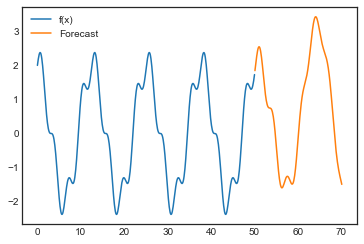

In [27]:
ax = df.plot()
df_forecast.plot(ax = ax);